In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Reshape
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback
from Kfocusing import FocusedLayer1D
from keras_utils import SGDwithLR, RMSpropwithClip,AdamwithClip
from keras.optimizers import RMSprop
from keras import backend as K

Using TensorFlow backend.
C:\Users\kakun\.conda\envs\win\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kakun\.conda\envs\win\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kakun\.conda\envs\win\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kakun\.conda\envs\win\lib\site-packages\tensorflow\py

The name for Record Variable has changed, use RecordWeights or RecordTensor instead
Not working!


# Credentials

In [4]:
lr_dict = {'all':0.01,
           'focus-1/Sigma:0': 0.01,'focus-1/Mu:0': 0.01,'focus-1/Weights:0': 0.01,
           'dense-1/Weights:0':0.01}
        
#lr_dict = {'all':0.0001}

mom_dict = {'all':0.9}
#decay_dict = {'all':0.9}
#mom_dict = {'all':0.9,'focus-1/Sigma:0': 0.25,'focus-1/Mu:0': 0.25,
#           'focus-2/Sigma:0': 0.25,'focus-2/Mu:0': 0.25}
    
decay_dict = {'all':0.9, 'focus-1/Sigma:0': 0.1,'focus-1/Mu:0':0.1}

clip_dict = {'focus-1/Sigma:0':(0.05,1.0),'focus-1/Mu:0':(0.0,1.0)}

#cridentals
mode = {'d':'dense'
        ,'f':'focused'}
optimizer_s = {'a':'adam'
              ,'sl':'SGDwithLR'
              ,'rc':'RMSpropwithClip'
              ,'ac':'AdamwithCli'}
episodes = 10000
iterations = 250

# Neural Network Model

In [18]:
def build_model(input_size
                ,output_size
                ,N=32
                ,mode='adam'
                ,optimizer_s='SGDwithLR'):
    
    model = Sequential()
    model.add(Dense(32, input_dim=input_size, activation='elu',name='dense-1'))
    if mode=='dense':
        model.add(Dense(32, activation='elu'))
    elif mode=='focused':
        model.add(FocusedLayer1D(units=N
                                 ,name='focus-1'
                                 ,activation='relu'
                                 ,init_sigma=0.25
                                 ,init_mu='spread'
                                 ,init_w= None
                                 ,train_sigma=True
                                 ,train_weights=True
                                 ,train_mu = True
                                 ,normed=2))
        
    model.add(Dense(output_size, activation='linear'))
    
    if optimizer_s == 'SGDwithLR':
        opt = SGDwithLR(lr_dict, mom_dict,decay_dict,clip_dict)
    elif optimizer_s == 'AdamwithCli':
        opt = AdamwithClip()
    elif optimizer_s=='RMSpropwithClip':
        opt = RMSpropwithClip(lr=0.001, rho=0.9, epsilon=None, decay=0.0,clips=clip_dict)
    elif optimizer_s=='adam':
        ##adam with clip
        opt = Adam(lr=1e-3)
    else:
        opt = SGD(lr=0.01, momentum=0.9)


    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    print(model.summary())

    return model

In [8]:
def train_model(training_data,mode,epochs,optimizer_s):
    X = np.array([i[0] for i in training_data]).reshape(-1, len(training_data[0][0]))
    y = np.array([i[1] for i in training_data]).reshape(-1, len(training_data[0][1]))
    model = build_model(input_size=len(X[0])
                        ,output_size=len(y[0])
                        ,mode=mode
                        ,optimizer_s=optimizer_s)

    history = model.fit(X, y, epochs=epochs)
    
    return model, history

# Plotting

In [9]:
def plotTheValues(scores):
    x = []
    y = []
    for i in range(0, len(scores)):
        x.append(int(i))
        y.append(int(scores[i]))

    plt.figure(figsize=(20, 15))

    plt.plot(x, y, label="score per run")

    plt.plot(x[-100:], [np.mean(y[-100:])] * len(y[-100:]), linestyle="--", label="last 100 runs average")

    trend_x = x[1:]
    z = np.polyfit(np.array(trend_x), np.array(y[1:]), 1)
    p = np.poly1d(z)
    plt.plot(trend_x, p(trend_x), linestyle="-.",  label="trend")


    plt.xlabel("episodes")
    plt.ylabel("scores")
    plt.legend(loc="upper left")

In [10]:
def statistic(scores, choices):
    choice = set(choices)
    print('Average Score: ',sum(scores)/len(scores))
    for i in choice:
        print(f"choice {i}:{mean(choices,i)}")

In [11]:
def lossAccComparison(dense, focused, name):
    plt.figure(figsize=(16,8))
    plt.title(name+'_loss_grahp')
    plt.plot(dense.history['loss'])
    plt.plot(focused.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['dense','focused'])
    plt.savefig('./graphs/'+name+'_loss_grahp.png', bbox_inches="tight")
    
    plt.figure(figsize=(16,8))
    plt.title(name+'_accuracy_grahp')
    plt.plot(dense.history['acc'])
    plt.plot(focused.history['acc'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['dense','focused'])
    plt.savefig('./graphs/'+name+'_accuracy_grahp.png', bbox_inches="tight")

In [12]:
mean = lambda lst, key: lst.count(key)/len(lst)

# Creating Data and Test Run on Environment

In [13]:
def training_data(envName,episodes):
    env = gym.make(envName)
    if envName == 'NChain-v0':
        observation_space=env.observation_space.n
    else:
        observation_space=len(env.observation_space.high)
    env.reset()
    training_data = []
    for _ in range(episodes):
        done = False # represents goal_steps
        score = 0
        game_memory = []
        previous_observation = []
        record = False
        while not done:
            action = np.random.randint(0, env.action_space.n)
            observation, reward, done, _ = env.step(action)

            if record:
                game_memory.append([previous_observation, action])

            record = True

            previous_observation = observation

            score += reward

        for data in game_memory:
            mem1 = np.zeros([observation_space])
            mem2 = np.zeros([env.action_space.n])
            if envName == 'NChain-v0':
                mem1[data[0]] = data[0]
            else:
                mem1=data[0]
            mem2[data[1]] = data[1]
            training_data.append([mem1, mem2])

        env.reset()

    return training_data

In [14]:
def test_run(envName,iterations,trained_model):
    env = gym.make(envName)
    env.reset()
    scores = []
    choices = []
    for each_game in range(iterations):
        score = 0
        prev_obs = []
        random = True
        done = False
        while not done:
            if random:
                action = np.random.randint(0, env.action_space.n)
                random = False
            else:
                # kitabın kodunu ekle
                action = np.argmax(trained_model.predict(prev_obs.reshape(-1, len(prev_obs)))[0])
                
            choices.append(action)
            new_observation, reward, done, _ = env.step(action)

            if envName == 'NChain-v0':
                obs = np.zeros([env.observation_space.n])
                obs[new_observation] = new_observation
            else:
                obs = new_observation
                
            prev_obs = obs

            score += reward

        env.reset()
        scores.append(score)
        
    return scores, choices

# NChain Section

In [188]:
K.clear_session()

env = 'NChain-v0'
epochs = 5

In [189]:
NChain_Training_Data = training_data(envName=env
                                     ,episodes=episodes)

In [190]:
NChain_trained_model_dense, NChain_model_history_dense = train_model(training_data=NChain_Training_Data
                                                                     ,mode=mode['d']
                                                                     ,epochs=epochs
                                                                     ,optimizer_s=optimizer_s['a'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense-1 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,314
Trainable params: 1,314
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
9990000/9990000 [==============================] - 287s 29us/step - loss: 0.1251 - acc: 0.5001
Epoch 2/5
9990000/9990000 [==============================] - 282s 28us/step - loss: 0.1250 - acc: 0.5001
Epoch 3/5
9990000/9990000 [==============================] - 278s 28us/step - loss: 0.1250 - acc: 0.5001
Epoch 4/5
9990000/9990000 [==============================] - 283s 28us/step - loss: 

In [191]:
NChain_trained_model_focused, NChain_model_history_focused = train_model(training_data=NChain_Training_Data
                                                                         ,mode=mode['f']
                                                                         ,epochs=epochs
                                                                         ,optimizer_s=optimizer_s['sl'])

{'name': 'focus-1'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense-1 (Dense)              (None, 32)                192       
_________________________________________________________________
focus-1 (FocusedLayer1D)     (None, 32)                1120      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,378
Trainable params: 1,378
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
9990000/9990000 [==============================] - 358s 36us/step - loss: 0.1252 - acc: 0.5001
Epoch 2/5
9990000/9990000 [==============================] - 348s 35us/step - loss: 0.1252 - acc: 0.5001
Epoch 3/5
9990000/9990000 [==============================] - 339s 34us/step - loss: 0.1252 - acc: 0.5001
Epoch 4/5
9990000/9990000 [==============================] - 337

In [209]:
NChain_dense_scores, NChain_dense_choices = test_run(envName=env
                                                     ,iterations=iterations
                                                     ,trained_model=NChain_trained_model_dense)

Average Score:  1602.16
choice 0:0.000484
choice 1:0.999516


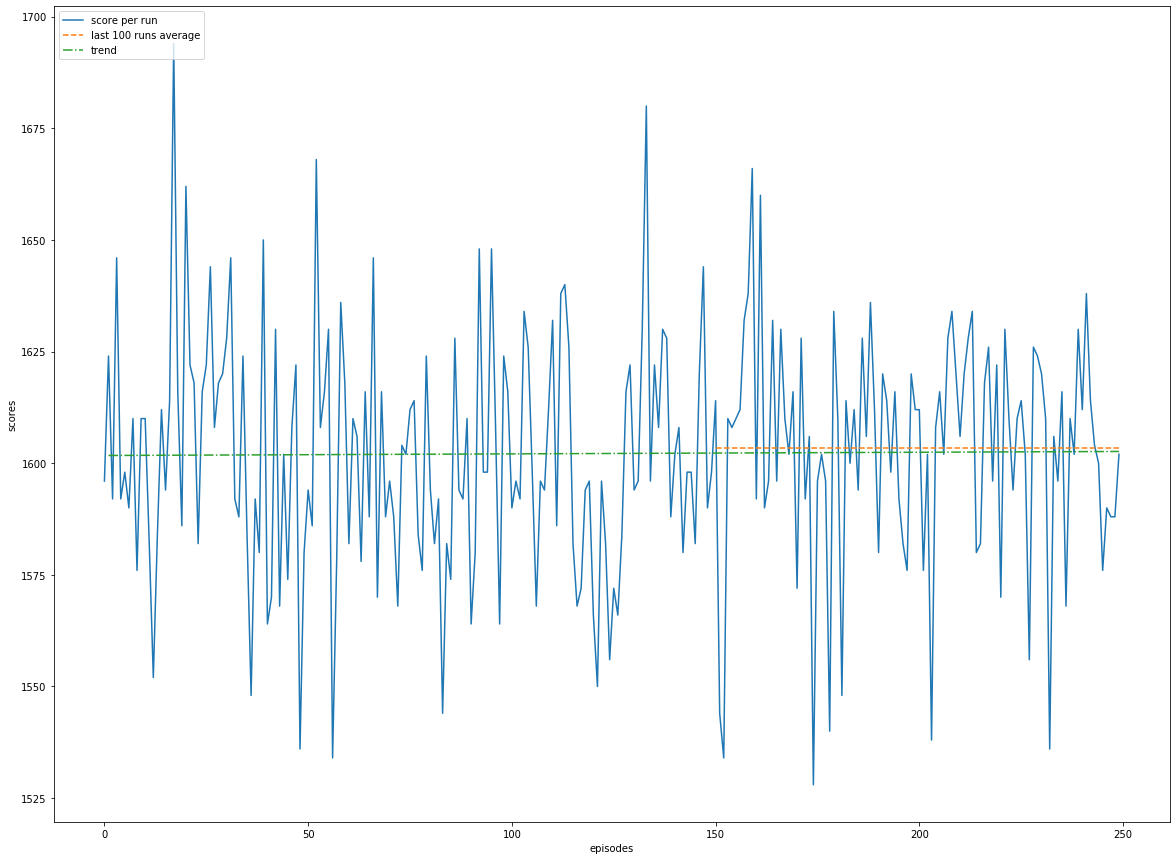

In [211]:
statistic(scores=NChain_dense_scores
          ,choices=NChain_dense_choices)
plotTheValues(scores=NChain_dense_scores)

# FocusedNN Graphs

In [214]:
NChain_focused_scores, NChain_focused_choices = test_run(envName=env
                                                         ,iterations=iterations
                                                         ,trained_model=NChain_trained_model_focused)

Average Score:  1602.384
choice 0:0.00052
choice 1:0.99948


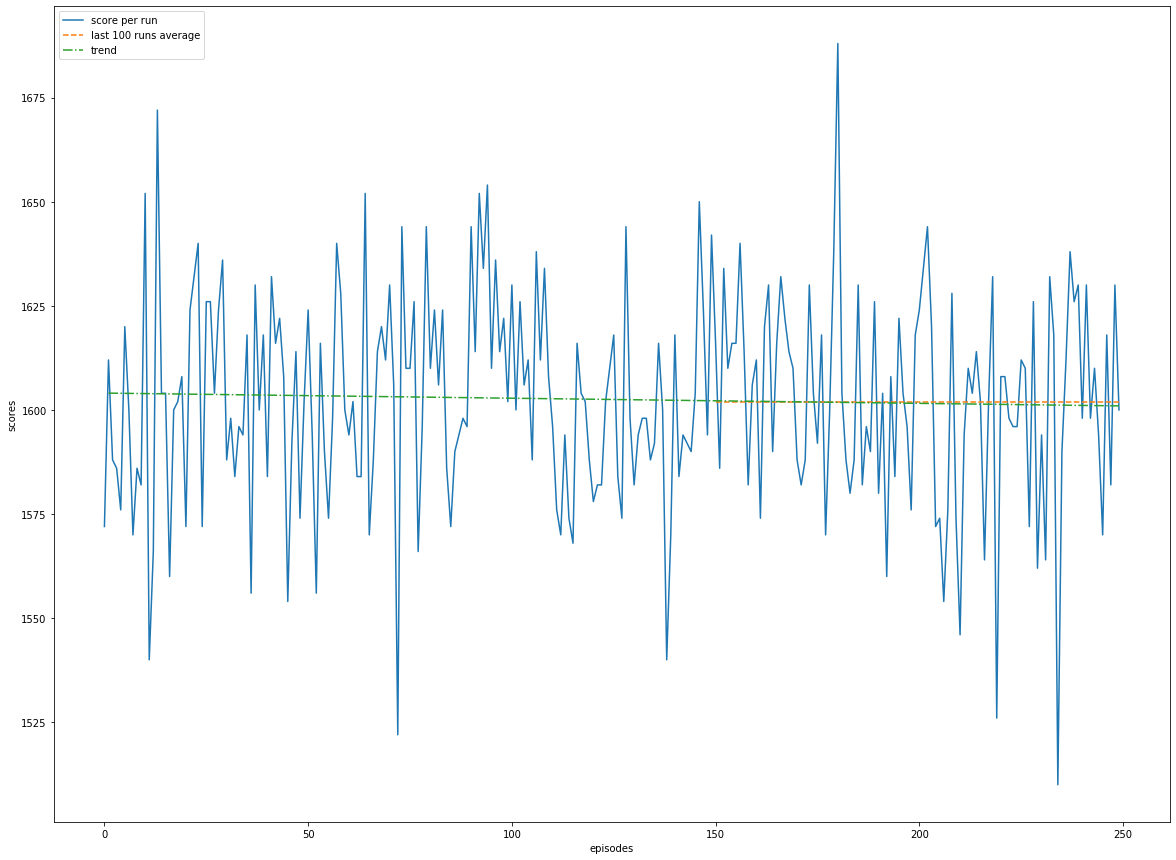

In [215]:
statistic(scores=NChain_focused_scores
          ,choices=NChain_focused_choices)
plotTheValues(scores=NChain_focused_scores)

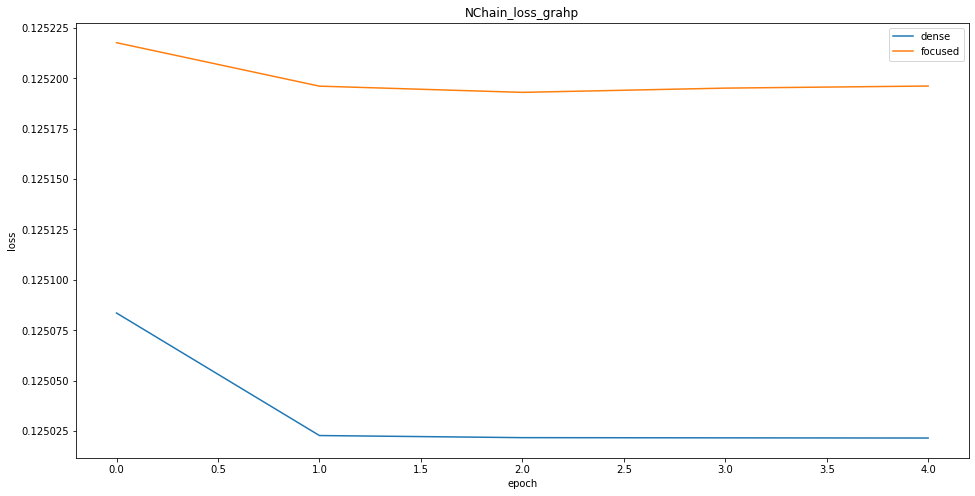

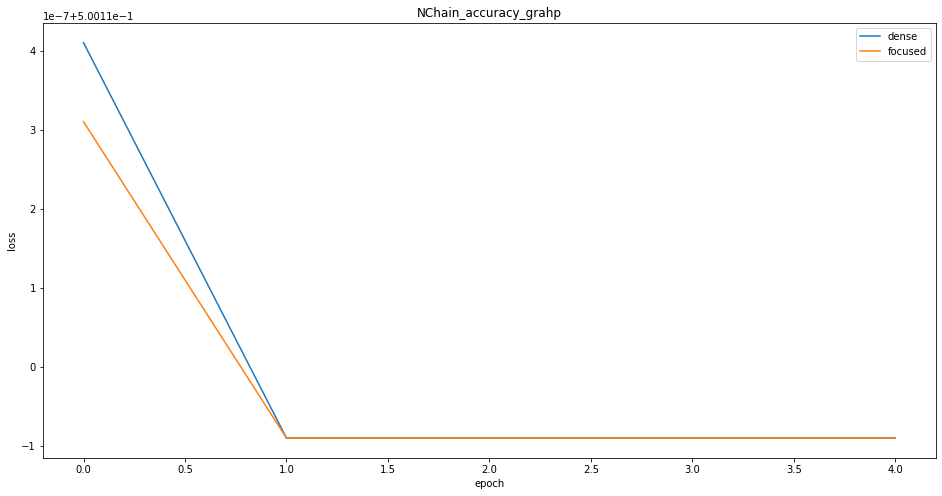

In [216]:
lossAccComparison(dense=NChain_model_history_dense
                 ,focused=NChain_model_history_focused
                 ,name='NChain')

# MountainCar section

In [152]:
K.clear_session()

env = 'MountainCar-v0'
epochs = 5

In [154]:
MountainCar_Training_Data = training_data(envName=env
                                          ,episodes=episodes)

In [155]:
MountainCar_trained_model_dense, MountainCar_model_history_dense = train_model(training_data=MountainCar_Training_Data
                                                                               ,mode=mode['d']
                                                                               ,epochs=epochs
                                                                               ,optimizer_s=optimizer_s['a'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense-1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1990000/1990000 [==============================] - 57s 29us/step - loss: 0.3708 - acc: 0.3336
Epoch 2/5
1990000/1990000 [==============================] - 56s 28us/step - loss: 0.3706 - acc: 0.3336
Epoch 3/5
1990000/1990000 [==============================] - 56s 28us/step - loss: 0.3706 - acc: 0.3336
Epoch 4/5
1990000/1990000 [==============================] - 59s 29us/step - loss: 0.37

In [156]:
MountainCar_trained_model_focused, MountainCar_model_history_focused = train_model(training_data=MountainCar_Training_Data
                                                                                   ,mode=mode['f']
                                                                                   ,epochs=epochs
                                                                                   ,optimizer_s=optimizer_s['sl'])

{'name': 'focus-1'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense-1 (Dense)              (None, 32)                96        
_________________________________________________________________
focus-1 (FocusedLayer1D)     (None, 32)                1120      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,315
Trainable params: 1,315
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1990000/1990000 [==============================] - 71s 36us/step - loss: 0.3709 - acc: 0.3336
Epoch 2/5
1990000/1990000 [==============================] - 74s 37us/step - loss: 0.3708 - acc: 0.3336
Epoch 3/5
1990000/1990000 [==============================] - 70s 35us/step - loss: 0.3709 - acc: 0.3336
Epoch 4/5
1990000/1990000 [==============================] - 71s 36

In [164]:
MountainCar_dense_scores, MountainCar_dense_choices = test_run(envName=env
                                                               ,iterations=iterations
                                                               ,trained_model=MountainCar_trained_model_dense)

Average Score:  -200.0
choice 1:0.00196 choice 0:0.00156 choice 2:0.99648


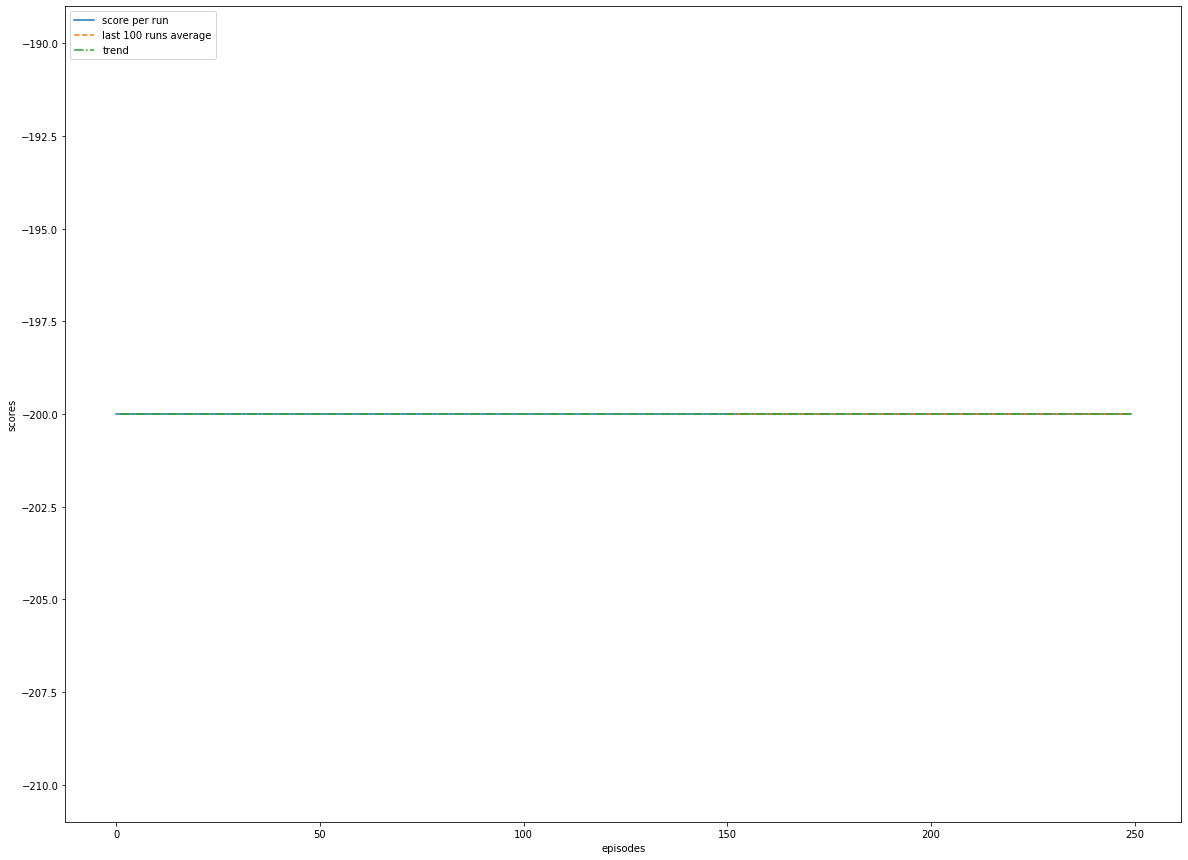

In [165]:
statistic(scores=MountainCar_dense_scores
          ,choices=MountainCar_dense_choices)
plotTheValues(scores=MountainCar_dense_scores)

# FocusedNN Graphs

In [166]:
MountainCar_focused_scores, MountainCar_focused_choices = test_run(envName=env
                                                                   ,iterations=iterations
                                                                   ,trained_model=MountainCar_trained_model_focused)

Average Score:  -200.0
choice 1:0.0019 choice 0:0.00158 choice 2:0.99652


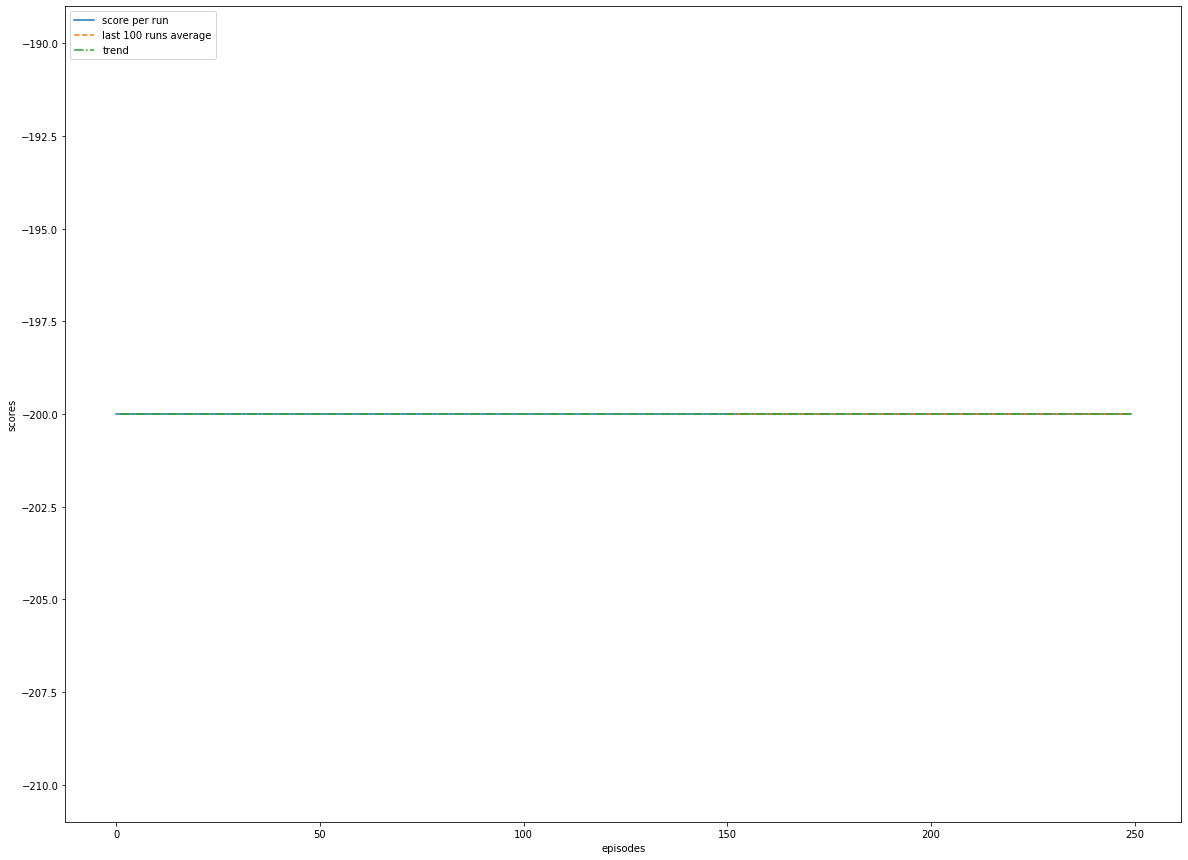

In [167]:
statistic(scores=MountainCar_focused_scores
          ,choices=MountainCar_focused_choices)
plotTheValues(scores=MountainCar_focused_scores)

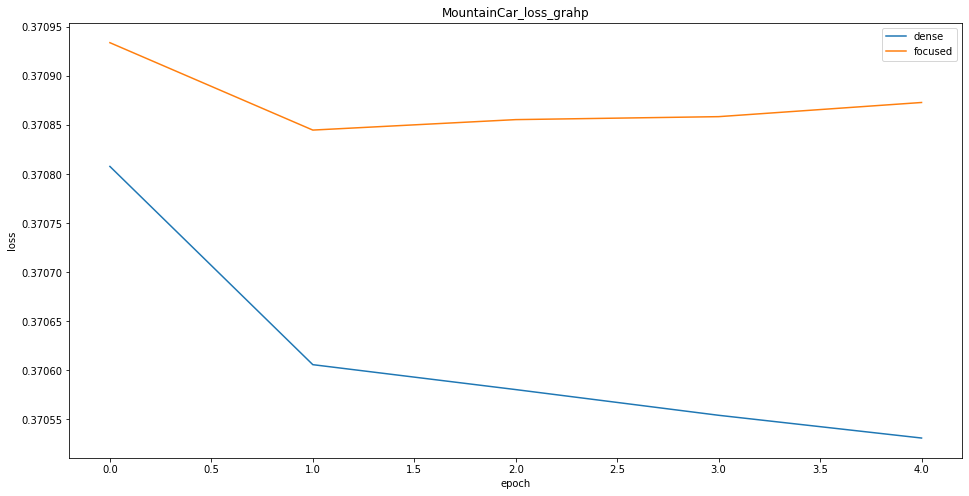

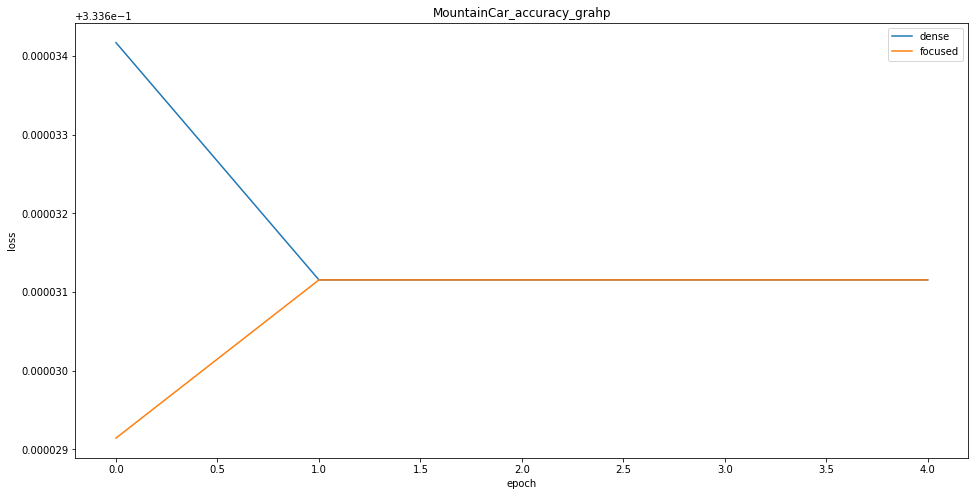

In [168]:
lossAccComparison(dense=MountainCar_model_history_dense
                 ,focused=MountainCar_model_history_focused
                 ,name='MountainCar')

# CartPole section

In [21]:
K.clear_session()

env = 'CartPole-v1'
epochs = 600

In [16]:
CartPole_Training_Data = training_data(envName=env
                                       ,episodes=episodes)

In [22]:
CartPole_trained_model_dense, CartPole_model_history_dense = train_model(training_data=CartPole_Training_Data
                                                                         ,mode=mode['d']
                                                                         ,epochs=epochs
                                                                         ,optimizer_s=optimizer_s['a'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense-1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/600
212470/212470 [==============================] - 8s 39us/step - loss: 0.3538 - acc: 0.7510
Epoch 2/600
212470/212470 [==============================] - 8s 37us/step - loss: 0.3475 - acc: 0.7490
Epoch 3/600
212470/212470 [==============================] - 8s 36us/step - loss: 0.3471 - acc: 0.7479
Epoch 4/600
212470/212470 [==============================] - 8s 39us/step - loss: 0.3469 -

212470/212470 [==============================] - 8s 37us/step - loss: 0.3466 - acc: 0.7496
Epoch 73/600
212470/212470 [==============================] - 8s 36us/step - loss: 0.3466 - acc: 0.7500
Epoch 74/600
212470/212470 [==============================] - 8s 36us/step - loss: 0.3466 - acc: 0.7498
Epoch 75/600
212470/212470 [==============================] - 7s 35us/step - loss: 0.3466 - acc: 0.7499
Epoch 76/600
212470/212470 [==============================] - 8s 35us/step - loss: 0.3466 - acc: 0.7502
Epoch 77/600
212470/212470 [==============================] - 7s 34us/step - loss: 0.3466 - acc: 0.7499
Epoch 78/600
212470/212470 [==============================] - 7s 34us/step - loss: 0.3467 - acc: 0.7488
Epoch 79/600
212470/212470 [==============================] - 7s 34us/step - loss: 0.3466 - acc: 0.7498
Epoch 80/600
212470/212470 [==============================] - 8s 36us/step - loss: 0.3466 - acc: 0.7503
Epoch 81/600
212470/212470 [==============================] - 8s 38us/step - 

212470/212470 [==============================] - 8s 36us/step - loss: 0.3466 - acc: 0.7497
Epoch 151/600
212470/212470 [==============================] - 6s 29us/step - loss: 0.3466 - acc: 0.7499
Epoch 152/600
212470/212470 [==============================] - 6s 29us/step - loss: 0.3466 - acc: 0.7500
Epoch 153/600
212470/212470 [==============================] - 6s 29us/step - loss: 0.3466 - acc: 0.7499
Epoch 154/600
212470/212470 [==============================] - 6s 29us/step - loss: 0.3466 - acc: 0.7497
Epoch 155/600
212470/212470 [==============================] - 6s 29us/step - loss: 0.3466 - acc: 0.7506
Epoch 156/600
212470/212470 [==============================] - 6s 29us/step - loss: 0.3466 - acc: 0.7500
Epoch 157/600
212470/212470 [==============================] - 6s 29us/step - loss: 0.3466 - acc: 0.7498
Epoch 158/600
212470/212470 [==============================] - 6s 29us/step - loss: 0.3466 - acc: 0.7497
Epoch 159/600
212470/212470 [==============================] - 6s 29u

KeyboardInterrupt: 

In [172]:
CartPole_trained_model_focused, CartPole_model_history_focused = train_model(training_data=CartPole_Training_Data
                                                                             ,mode=mode['f']
                                                                             ,epochs=epochs
                                                                             ,optimizer_s=optimizer_s['sl'])

{'name': 'focus-1'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense-1 (Dense)              (None, 32)                160       
_________________________________________________________________
focus-1 (FocusedLayer1D)     (None, 32)                1120      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,346
Trainable params: 1,346
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
211147/211147 [==============================] - 8s 36us/step - loss: 0.1256 - acc: 0.5001
Epoch 2/10
211147/211147 [==============================] - 7s 34us/step - loss: 0.1252 - acc: 0.5001
Epoch 3/10
211147/211147 [==============================] - 7s 34us/step - loss: 0.1252 - acc: 0.5001
Epoch 4/10
211147/211147 [==============================] - 8s 36us/step 

In [19]:
CartPole_dense_scores, CartPole_dense_choices = test_run(envName=env
                                                         ,iterations=iterations
                                                         ,trained_model=CartPole_trained_model_dense)

Average Score:  10.412
choice 0:0.04648482520169036
choice 1:0.9535151747983096


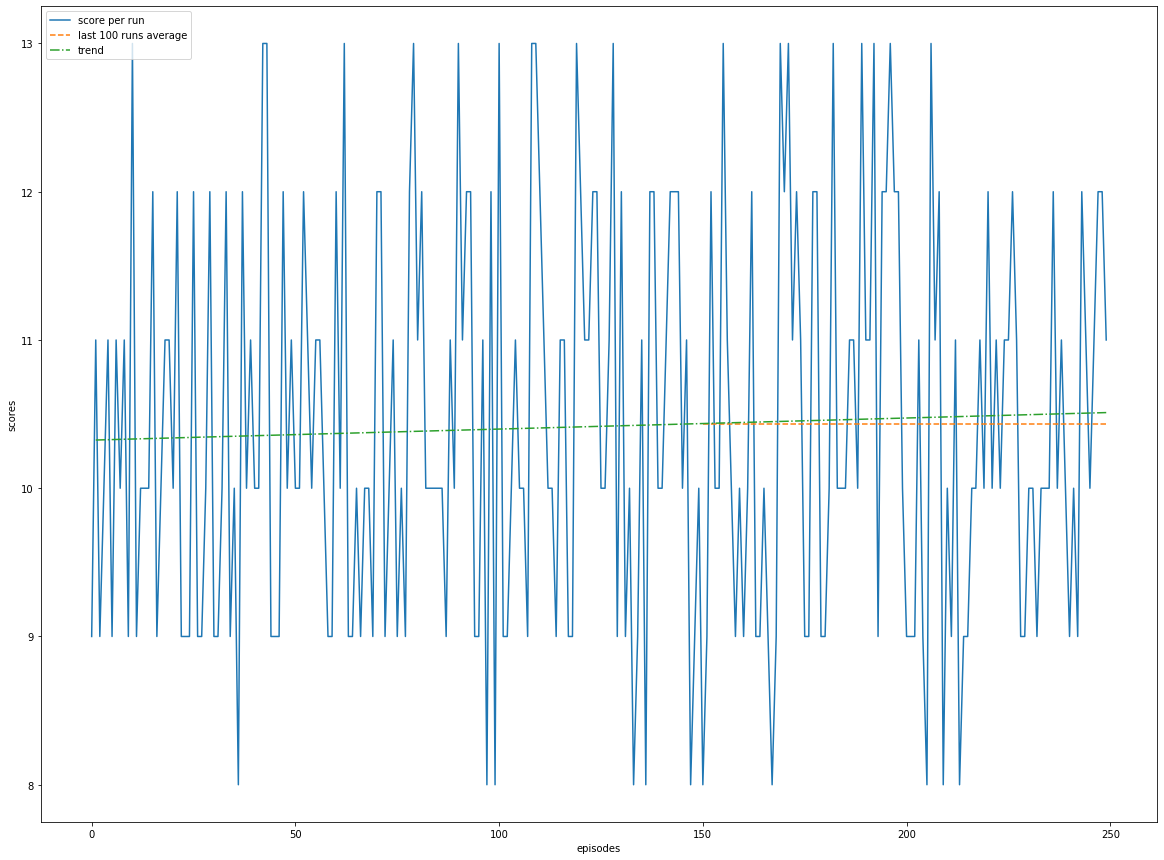

In [20]:
statistic(scores=CartPole_dense_scores
          ,choices=CartPole_dense_choices)
plotTheValues(scores=CartPole_dense_scores)

# FocusedNN Graphs

In [185]:
CartPole_focused_scores, CartPole_focused_choices = test_run(envName=env
                                                             ,iterations=iterations
                                                             ,trained_model=CartPole_trained_model_dense)

Average Score:  10.58
choice 0:0.04934965570007651
choice 1:0.9506503442999235


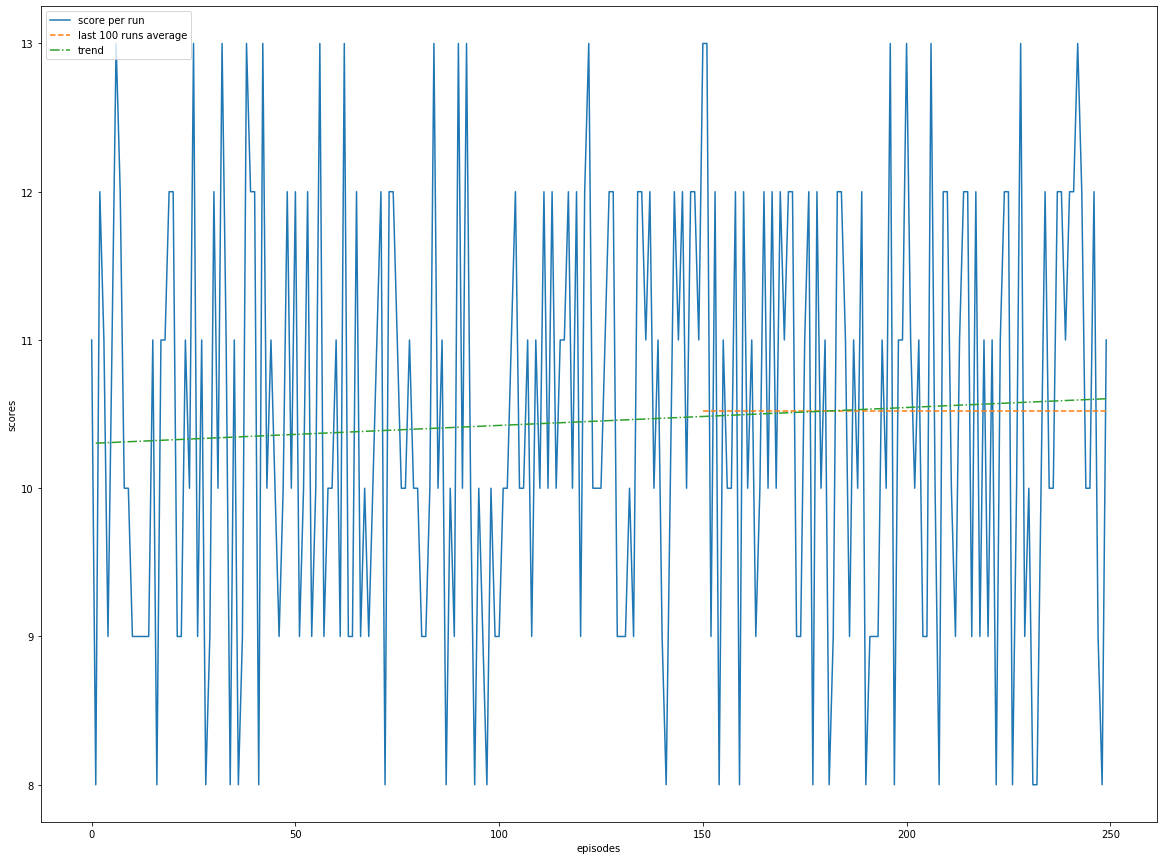

In [186]:
statistic(scores=CartPole_focused_scores
          ,choices=CartPole_focused_choices)
plotTheValues(scores=CartPole_focused_scores)

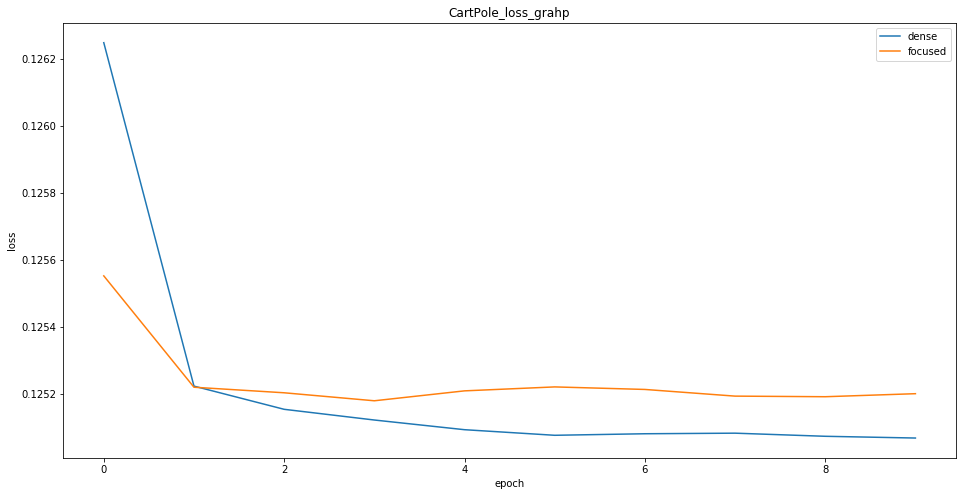

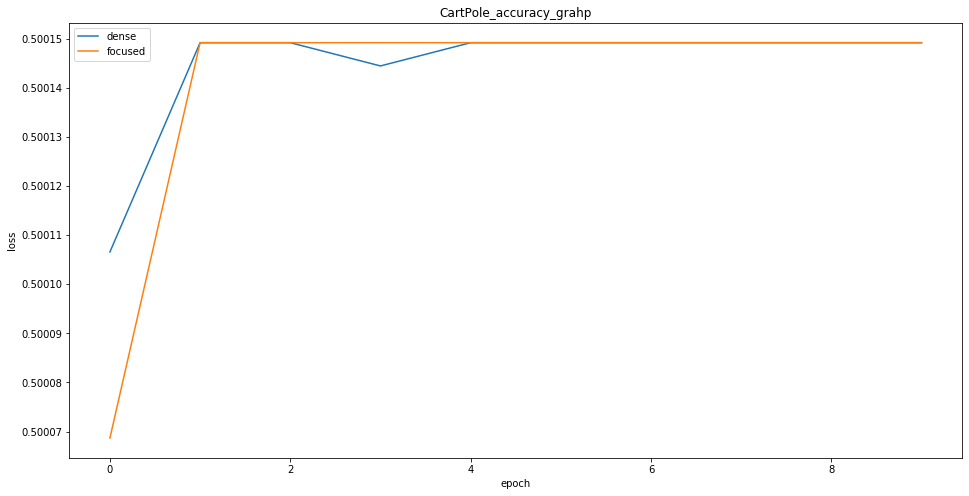

In [187]:
lossAccComparison(dense=CartPole_model_history_dense
                 ,focused=CartPole_model_history_focused
                 ,name='CartPole')